# Model1 

Classical feed forward neural network implemented in Keras with Tensorflow 

Features:
* Feature engineering: boolean flags that indicate that user watched at least one lecture of each type
* Feature engineering: features from question dataset
* Feature engineering: fill 'prior_question_elapsed_time' empty values with mean value
* Target encoding using all train data
* Standard scaling of 'prior_question_elapsed_time'
* Keras
* Optuna to find optimal NN parameters

Model taken from https://www.kaggle.com/pavelvpster/riiid-fe-target-encoding-keras 

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter('ignore')

import gc, sys
gc.enable()

import os
for dirname, _, filenames in os.walk('../data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data\example_sample_submission.csv
../data\example_test.csv
../data\lectures.csv
../data\questions.csv
../data\SAKT-HDKIM.pt
../data\train.csv
../data\train0.csv
../data\train1.csv
../data\train2.csv
../data\train3.csv
../data\train4.csv
../data\train5.csv
../data\training_set_example.csv
../data\riiideducation\competition.cpython-37m-x86_64-linux-gnu.so
../data\riiideducation\__init__.py
../data\riiideducation\__pycache__\__init__.cpython-38.pyc


## Load data

Load more train data. Keep records where user last time answers a question.

In [2]:
chunksize = 10**5

In [3]:
train = None

load_count = 0

for load_train in pd.read_csv('../data/train.csv', chunksize=chunksize, iterator=True):
    
    load_train = load_train[load_train['answered_correctly'] != -1]
    
    load_train['user_id__content_id'] = load_train['user_id'].astype(str) + '__' + load_train['content_id'].astype(str)
    
    load_train = load_train.drop_duplicates('user_id__content_id', keep = 'last')
    
    if train is None:
        train = load_train
    else:
        train = pd.concat([train, load_train]).drop_duplicates('user_id__content_id', keep = 'last')
    
    load_count += chunksize
    print('Rows processed:', load_count, 'Train set size:', train.shape[0])
    
    if load_count >= 2 * chunksize:
        break

Rows processed: 100000 Train set size: 85395
Rows processed: 200000 Train set size: 173223


In [4]:
lectures = pd.read_csv("../data/lectures.csv")

In [5]:
questions = pd.read_csv("../data/questions.csv")

## Feature engineering

In [6]:
question_columns = ['question_id', 'bundle_id', 'part']


def merge_question_columns(data):
    return data.merge(questions[question_columns], right_on='question_id', left_on='content_id', how='left')

In [7]:
train = merge_question_columns(train)

### Per user lecture stats

Do OHE for some lectures features

In [8]:
lectures['type_of'] = lectures['type_of'].replace('solving question', 'solving_question')

lectures = pd.get_dummies(lectures, columns=['part', 'type_of'])

part_lectures_columns = [column for column in lectures.columns if column.startswith('part')]

types_of_lectures_columns = [column for column in lectures.columns if column.startswith('type_of_')]

In [9]:
lectures.head(10).T

0    1    2    3    4    5    6    7    8    9
lecture_id                 89  100  185  192  317  335  484  641  761  814
tag                       159   70   45   79  156  114  179  134   93   80
part_1                      0    1    0    0    0    0    0    0    1    0
part_2                      0    0    0    0    0    1    0    0    0    0
part_3                      0    0    0    0    0    0    0    0    0    0
part_4                      0    0    0    0    0    0    0    0    0    0
part_5                      1    0    0    1    1    0    1    0    0    1
part_6                      0    0    1    0    0    0    0    1    0    0
part_7                      0    0    0    0    0    0    0    0    0    0
type_of_concept             1    1    1    0    0    1    1    0    1    0
type_of_intention           0    0    0    0    0    0    0    0    0    0
type_of_solving_question    0    0    0    1    1    0    0    1    0    1
type_of_starter             0    0    0    0    0    0    0    0    0    0

Collect per user lecture stats

In [10]:
user_lecture_stats = None


def collect_user_lecture_stats(train):
    
    # merge lecture features to train dataset
    train_lectures = train[train['content_type_id'] == 1].merge(lectures, right_on='lecture_id', left_on='content_id', how='left')
    
    # collect per user stats
    user_lecture_stats_part = train_lectures.groupby('user_id')[part_lectures_columns + types_of_lectures_columns].sum()
    
    # add boolean features
    for column in user_lecture_stats_part.columns:
        bool_column = column + '_boolean'
        user_lecture_stats_part[bool_column] = (user_lecture_stats_part[column] > 0).astype(int)
    
    return user_lecture_stats_part

def update_user_lecture_stats(user_lecture_stats_part):
    global user_lecture_stats
    if user_lecture_stats is None:
        user_lecture_stats = user_lecture_stats_part
    else:
        user_lecture_stats = user_lecture_stats.add(user_lecture_stats_part, fill_value=0.)

def merge_user_lecture_stats(data):
    return data.merge(user_lecture_stats, left_on='user_id', right_index=True, how='left').fillna(0)

### Target encoding

In [11]:
from collections import Counter


per_value_counts = {}
global_counts = Counter()


columns_target_encode = ['user_id', 'content_id', 'task_container_id',
                         'bundle_id', 'part']


def add_or_update(column, value, count, answered_correctly):
    # column
    column_data = per_value_counts.get(column, {})
    per_value_counts[column] = column_data
    # value
    value_data = column_data.get(value, Counter())
    column_data[value] = value_data
    # counters
    value_data += Counter({'count': count, 'answered_correctly': answered_correctly})

def update_counts(data, column):
    agg = data.groupby(column)['answered_correctly'].agg(['count', 'mean'])
    agg['answered_correctly'] = agg['count'] * agg['mean']
    for idx,row in agg.iterrows():
        add_or_update(column, idx, row['count'], row['answered_correctly'])

def update_global_counts(data):
    global global_counts
    count = data.shape[0]
    clicks = data[data['answered_correctly'] == 1].shape[0]
    global_counts += Counter({'count': count, 'answered_correctly': clicks})

def update_all_counts(data, columns):
    for column in columns:
        update_counts(data, column)
    update_global_counts(data)

def target_encode_value(column, value):
    counts = per_value_counts.get(column, {}).get(value, Counter())
    if 'answered_correctly' in counts:
        return counts['answered_correctly'] / counts['count']
    else:
        return global_counts['answered_correctly'] / global_counts['count']

def target_encode(data, columns):
    out = pd.DataFrame(index=data.index)
    for column in columns:
        out[column] = data[column].apply(lambda value: target_encode_value(column, value))
    return out

### Standard scaling

In [12]:
from sklearn.preprocessing import StandardScaler


columns_std = ['prior_question_elapsed_time']


scaler = StandardScaler()

### Warmup using all train data

In [13]:
warmup_count = 0

for warmup_train in pd.read_csv('../data/train1.csv', chunksize=chunksize, iterator=True):
    
    update_user_lecture_stats(collect_user_lecture_stats(warmup_train))
    
    warmup_train = warmup_train[warmup_train['answered_correctly'] != -1]
    
    warmup_train = merge_question_columns(warmup_train)
    
    update_all_counts(warmup_train, columns_target_encode)
    
    scaler.partial_fit(warmup_train[columns_std])
    
    warmup_count += chunksize
    # print('Rows processed:', warmup_count)

In [14]:
user_lecture_stats.head(10).T

user_id                           2746   5382   8623   12741  13134  24418  \
part_1                              0.0    1.0    2.0    0.0    1.0   21.0   
part_2                              1.0    0.0    1.0    0.0    3.0   44.0   
part_3                              0.0    0.0    0.0    0.0    0.0   13.0   
part_4                              0.0    0.0    0.0    3.0    0.0    7.0   
part_5                              0.0    2.0    0.0    0.0    3.0   84.0   
part_6                              0.0    0.0    0.0    1.0    0.0   12.0   
part_7                              0.0    0.0    0.0    2.0    0.0    0.0   
type_of_concept                     0.0    3.0    3.0    4.0    6.0   93.0   
type_of_intention                   1.0    0.0    0.0    0.0    1.0    5.0   
type_of_solving_question            0.0    0.0    0.0    2.0    0.0   83.0   
type_of_starter                     0.0    0.0    0.0    0.0    0.0    0.0   
part_1_boolean                      0.0    1.0    1.0    0.0    1.0    1.0   
part_2_boolean                      1.0    0.0    1.0    0.0    1.0    1.0   
part_3_boolean                      0.0    0.0    0.0    0.0    0.0    1.0   
part_4_boolean                      0.0    0.0    0.0    1.0    0.0    1.0   
part_5_boolean                      0.0    1.0    0.0    0.0    1.0    1.0   
part_6_boolean                      0.0    0.0    0.0    1.0    0.0    1.0   
part_7_boolean                      0.0    0.0    0.0    1.0    0.0    0.0   
type_of_concept_boolean             0.0    1.0    1.0    1.0    1.0    1.0   
type_of_intention_boolean           1.0    0.0    0.0    0.0    1.0    1.0   
type_of_solving_question_boolean    0.0    0.0    0.0    1.0    0.0    1.0   
type_of_starter_boolean             0.0    0.0    0.0    0.0    0.0    0.0   

user_id                           40828  44331  46886  91216  
part_1                              0.0    1.0    0.0    0.0  
part_2                              0.0    0.0    1.0    5.0  
part_3                              0.0    0.0    0.0    0.0  
part_4                              0.0    0.0    0.0    0.0  
part_5                              1.0    0.0    0.0   41.0  
part_6                              0.0    2.0    0.0    6.0  
part_7                              0.0    0.0    0.0    0.0  
type_of_concept                     1.0    3.0    0.0   39.0  
type_of_intention                   0.0    0.0    0.0    3.0  
type_of_solving_question            0.0    0.0    1.0   10.0  
type_of_starter                     0.0    0.0    0.0    0.0  
part_1_boolean                      0.0    1.0    0.0    0.0  
part_2_boolean                      0.0    0.0    1.0    1.0  
part_3_boolean                      0.0    0.0    0.0    0.0  
part_4_boolean                      0.0    0.0    0.0    0.0  
part_5_boolean                      1.0    0.0    0.0    1.0  
part_6_boolean                      0.0    1.0    0.0    1.0  
part_7_boolean                      0.0    0.0    0.0    0.0  
type_of_concept_boolean             1.0    1.0    0.0    1.0  
type_of_intention_boolean           0.0    0.0    0.0    1.0  
type_of_solving_question_boolean    0.0    0.0    1.0    1.0  
type_of_starter_boolean             0.0    0.0    0.0    0.0

In [15]:
user_lecture_stats_boolean_columns = [column for column in user_lecture_stats.columns if column.endswith('_boolean')]

user_lecture_stats_boolean_columns

['part_1_boolean',
 'part_2_boolean',
 'part_3_boolean',
 'part_4_boolean',
 'part_5_boolean',
 'part_6_boolean',
 'part_7_boolean',
 'type_of_concept_boolean',
 'type_of_intention_boolean',
 'type_of_solving_question_boolean',
 'type_of_starter_boolean']

## Prepare x, y

In [16]:
columns_copy = ['prior_question_had_explanation']


def make_x(data):
    
    # copy without changes
    x = data[columns_copy + ['user_id']].fillna(0)
    
    # convert Bool to Int
    x['prior_question_had_explanation'] = x['prior_question_had_explanation'].astype(int)
    
    # merge per user lecture stats
    x_lecture_stats = merge_user_lecture_stats(x)[user_lecture_stats_boolean_columns]
    
    x = x.drop('user_id', axis=1)
    
    # target encode
    x_target_encode = target_encode(data, columns_target_encode)
    
    # std
    x_std = pd.DataFrame(scaler.transform(data[columns_std]), index=data.index, columns=columns_std)
    for i,column in enumerate(x_std.columns):
        x_std[column].fillna(scaler.mean_[i], inplace=True)
    
    return pd.concat([x, x_lecture_stats, x_target_encode, x_std], axis=1)

In [17]:
x_train = make_x(train)

y_train = train['answered_correctly']

del train
gc.collect()

15

In [18]:
x_train.head(10).T

0         1         2         3  \
prior_question_had_explanation        0.000000  0.000000  0.000000  0.000000   
part_1_boolean                        0.000000  0.000000  0.000000  0.000000   
part_2_boolean                        0.000000  0.000000  0.000000  0.000000   
part_3_boolean                        0.000000  0.000000  0.000000  0.000000   
part_4_boolean                        0.000000  0.000000  0.000000  0.000000   
part_5_boolean                        0.000000  0.000000  0.000000  0.000000   
part_6_boolean                        0.000000  0.000000  0.000000  0.000000   
part_7_boolean                        0.000000  0.000000  0.000000  0.000000   
type_of_concept_boolean               0.000000  0.000000  0.000000  0.000000   
type_of_intention_boolean             0.000000  0.000000  0.000000  0.000000   
type_of_solving_question_boolean      0.000000  0.000000  0.000000  0.000000   
type_of_starter_boolean               0.000000  0.000000  0.000000  0.000000   
user_id                               0.695652  0.695652  0.695652  0.695652   
content_id                            0.681081  0.784483  0.967391  0.959596   
task_container_id                     0.518098  0.422848  0.700864  0.544667   
bundle_id                             0.681081  0.784483  0.967391  0.959596   
part                                  0.608572  0.608572  0.731964  0.731964   
prior_question_elapsed_time       24935.926215  0.623046  1.552651 -0.306559   

                                         4         5         6         7  \
prior_question_had_explanation    0.000000  0.000000  0.000000  0.000000   
part_1_boolean                    0.000000  0.000000  0.000000  0.000000   
part_2_boolean                    0.000000  0.000000  0.000000  0.000000   
part_3_boolean                    0.000000  0.000000  0.000000  0.000000   
part_4_boolean                    0.000000  0.000000  0.000000  0.000000   
part_5_boolean                    0.000000  0.000000  0.000000  0.000000   
part_6_boolean                    0.000000  0.000000  0.000000  0.000000   
part_7_boolean                    0.000000  0.000000  0.000000  0.000000   
type_of_concept_boolean           0.000000  0.000000  0.000000  0.000000   
type_of_intention_boolean         0.000000  0.000000  0.000000  0.000000   
type_of_solving_question_boolean  0.000000  0.000000  0.000000  0.000000   
type_of_starter_boolean           0.000000  0.000000  0.000000  0.000000   
user_id                           0.695652  0.695652  0.695652  0.695652   
content_id                        0.939024  0.902913  0.910891  0.833333   
task_container_id                 0.489184  0.402911  0.321129  0.510293   
bundle_id                         0.939024  0.902913  0.910891  0.833333   
part                              0.731964  0.731964  0.731964  0.731964   
prior_question_elapsed_time      -0.719717 -1.029585 -0.409849 -0.409849   

                                         8         9  
prior_question_had_explanation    0.000000  0.000000  
part_1_boolean                    0.000000  0.000000  
part_2_boolean                    0.000000  0.000000  
part_3_boolean                    0.000000  0.000000  
part_4_boolean                    0.000000  0.000000  
part_5_boolean                    0.000000  0.000000  
part_6_boolean                    0.000000  0.000000  
part_7_boolean                    0.000000  0.000000  
type_of_concept_boolean           0.000000  0.000000  
type_of_intention_boolean         0.000000  0.000000  
type_of_solving_question_boolean  0.000000  0.000000  
type_of_starter_boolean           0.000000  0.000000  
user_id                           0.695652  0.695652  
content_id                        0.940000  0.915888  
task_container_id                 0.499197  0.444325  
bundle_id                         0.940000  0.915888  
part                              0.731964  0.731964  
prior_question_elapsed_time      -0.461493 -0.461493

## Keras

In [19]:
import tensorflow as tf
import tensorflow_addons as tfa

import tensorflow.keras.backend as K

In [20]:
def make_layer(x, units, dropout_rate):
    t = tfa.layers.WeightNormalization(tf.keras.layers.Dense(units))(x)
    t = tf.keras.layers.BatchNormalization()(t)
    t = tf.keras.layers.Activation('relu')(t)
    t = tf.keras.layers.Dropout(dropout_rate)(t)
    return t


def make_model(columns, units, dropout_rates):
    
    inputs = tf.keras.layers.Input(shape=(columns,))
    x = tf.keras.layers.BatchNormalization()(inputs)

    for i in range(len(units)):
        u = units[i]
        d = dropout_rates[i]
        x = make_layer(x, u, d)
       
    y = tf.keras.layers.Dense(1, activation='sigmoid', name='dense_output')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=y)
    model.compile(loss='binary_crossentropy',
                  optimizer=tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5),
                  metrics=['accuracy'])
    return model

In [21]:
from sklearn.model_selection import KFold


def fit_validate(n_splits, x_train, y_train, units, dropout_rates, epochs, verbose, random_state):

    estimators = []
    histories = []
    
    scores = []

    cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    for train_idx, valid_idx in cv.split(x_train, y_train):

        x_train_train = x_train.iloc[train_idx]
        y_train_train = y_train.iloc[train_idx]
        x_train_valid = x_train.iloc[valid_idx]
        y_train_valid = y_train.iloc[valid_idx]

        K.clear_session()
        
        es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=10,
                                              verbose=verbose, mode='max', restore_best_weights=True)

        rl = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, min_lr=1e-5,
                                                  mode='max', verbose=verbose)

        estimator = make_model(x_train.shape[1], units, dropout_rates)

        history = estimator.fit(x_train_train, y_train_train,
                                batch_size=128, epochs=epochs, callbacks=[es, rl],
                                validation_data=(x_train_valid, y_train_valid),
                                verbose=verbose)
        
        estimators.append(estimator)
        histories.append(history)
        
        scores.append(history.history['val_accuracy'][-1])
    
    score = np.mean(scores)
    
    return estimators, histories, score

In [22]:
import optuna

from logging import CRITICAL
optuna.logging.set_verbosity(CRITICAL)


def objective(trial):
    
    n_layers = trial.suggest_int('n_layers', 1, 5)
    
    units = []
    dropout_rates = []
    for i in range(n_layers):
        u = trial.suggest_categorical('units_{}'.format(i+1), [16, 32, 64, 128])
        units.append(u)
        r = trial.suggest_loguniform('dropout_rate_{}'.format(i+1), 0.1, 0.5)
        dropout_rates.append(r)
    
    print('Units:', units, "Dropout rates:", dropout_rates)
    
    _, _, score = fit_validate(3, x_train, y_train, units, dropout_rates, 10, 0, 42)
    print('Score:', score)
    
    return score


#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=100)

In [24]:
# params1 = study.best_trial.params
# params1

In [25]:
params = {
    'n_layers': 2,
    'units_1': 128,
    'dropout_rate_1': 0.17611238698284856,
    'units_2': 128,
    'dropout_rate_2': 0.21305839482861083
} #score: 0.7670979102452596

# params = {
#     'n_layers': 2,
#     'units_1': 128,
#     'dropout_rate_1': 0.16206604468576866,
#     'units_2': 64,
#     'dropout_rate_2': 0.11094645790820698
# } #score: 0,76696
# params = {
#     'n_layers': 2,
#     'units_1': 128,
#     'dropout_rate_1': 0.1576269633262961,
#     'units_2': 64,
#     'dropout_rate_2': 0.26394371768001645
# }
params

{'n_layers': 2,
 'units_1': 128,
 'dropout_rate_1': 0.17611238698284856,
 'units_2': 128,
 'dropout_rate_2': 0.21305839482861083}

In [26]:
K.clear_session()


n_layers = params['n_layers']
units = []
dropout_rates = []
for i in range(n_layers):
    u = params['units_{}'.format(i+1)]
    units.append(u)
    d = params['dropout_rate_{}'.format(i+1)]
    dropout_rates.append(d)


estimators, histories, score = fit_validate(10, x_train, y_train, units, dropout_rates, 50, 2, 42) #orig fit_validate(3

Epoch 1/50
1218/1218 - 15s - loss: 0.5054 - accuracy: 0.7534 - val_loss: 0.4878 - val_accuracy: 0.7627
Epoch 2/50
1218/1218 - 3s - loss: 0.4913 - accuracy: 0.7621 - val_loss: 0.4866 - val_accuracy: 0.7625
Epoch 3/50
1218/1218 - 3s - loss: 0.4886 - accuracy: 0.7631 - val_loss: 0.4869 - val_accuracy: 0.7633
Epoch 4/50
1218/1218 - 3s - loss: 0.4879 - accuracy: 0.7644 - val_loss: 0.4846 - val_accuracy: 0.7649
Epoch 5/50
1218/1218 - 5s - loss: 0.4873 - accuracy: 0.7645 - val_loss: 0.4857 - val_accuracy: 0.7636
Epoch 6/50
1218/1218 - 7s - loss: 0.4865 - accuracy: 0.7653 - val_loss: 0.4849 - val_accuracy: 0.7649
Epoch 7/50
1218/1218 - 6s - loss: 0.4862 - accuracy: 0.7648 - val_loss: 0.4859 - val_accuracy: 0.7655
Epoch 8/50
1218/1218 - 6s - loss: 0.4860 - accuracy: 0.7650 - val_loss: 0.4844 - val_accuracy: 0.7645
Epoch 9/50
1218/1218 - 6s - loss: 0.4849 - accuracy: 0.7656 - val_loss: 0.4841 - val_accuracy: 0.7659
Epoch 10/50
1218/1218 - 6s - loss: 0.4850 - accuracy: 0.7652 - val_loss: 0.4837 -

Epoch 7/50
1218/1218 - 5s - loss: 0.4867 - accuracy: 0.7647 - val_loss: 0.4765 - val_accuracy: 0.7738
Epoch 8/50
1218/1218 - 5s - loss: 0.4867 - accuracy: 0.7647 - val_loss: 0.4766 - val_accuracy: 0.7731
Epoch 9/50
1218/1218 - 5s - loss: 0.4859 - accuracy: 0.7645 - val_loss: 0.4781 - val_accuracy: 0.7728
Epoch 10/50
1218/1218 - 3s - loss: 0.4857 - accuracy: 0.7648 - val_loss: 0.4765 - val_accuracy: 0.7738

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 11/50
1218/1218 - 3s - loss: 0.4840 - accuracy: 0.7655 - val_loss: 0.4758 - val_accuracy: 0.7753
Epoch 12/50
1218/1218 - 3s - loss: 0.4831 - accuracy: 0.7658 - val_loss: 0.4756 - val_accuracy: 0.7750
Epoch 13/50
1218/1218 - 5s - loss: 0.4832 - accuracy: 0.7660 - val_loss: 0.4751 - val_accuracy: 0.7749
Epoch 14/50
1218/1218 - 6s - loss: 0.4832 - accuracy: 0.7665 - val_loss: 0.4750 - val_accuracy: 0.7753

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 15/50
121

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Epoch 1/50
1218/1218 - 6s - loss: 0.5058 - accuracy: 0.7539 - val_loss: 0.4785 - val_accuracy: 0.7665
Epoch 2/50
1218/1218 - 3s - loss: 0.4913 - accuracy: 0.7627 - val_loss: 0.4775 - val_accuracy: 0.7678
Epoch 3/50
1218/1218 - 4s - loss: 0.4898 - accuracy: 0.7628 - val_loss: 0.4778 - val_accuracy: 0.7681
Epoch 4/50
1218/1218 - 6s - loss: 0.4889 - accuracy: 0.7641 - val_loss: 0.4760 - val_accuracy: 0.7693
Epoch 5/50
1218/1218 - 6s - loss: 0.4882 - accuracy: 0.7635 - val_loss: 0.4761 - val_accuracy: 0.7691
Epoch 6/50
1218/1218 - 6s - loss: 0.4874 - accuracy: 0.7643 - val_loss: 0.4756 - val_accuracy: 0.7678
Epoch 7/50
1218/1218 - 6s - loss: 0.4874 - accuracy: 0.7651 - val_loss: 0.4755 - val_accuracy: 0.7692

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 8/50
1218/1218 - 5s - loss: 0.4854 - accuracy: 0.7654 - val_loss: 0.4749 - val_accuracy: 0.7717
Epoch 9/50
1218/12

In [27]:
print('Validation score:', score)

Validation score: 0.7676636934280395


In [28]:
del x_train
del y_train
gc.collect()

27574

In [29]:
display(len(units))

2

## Show graphs

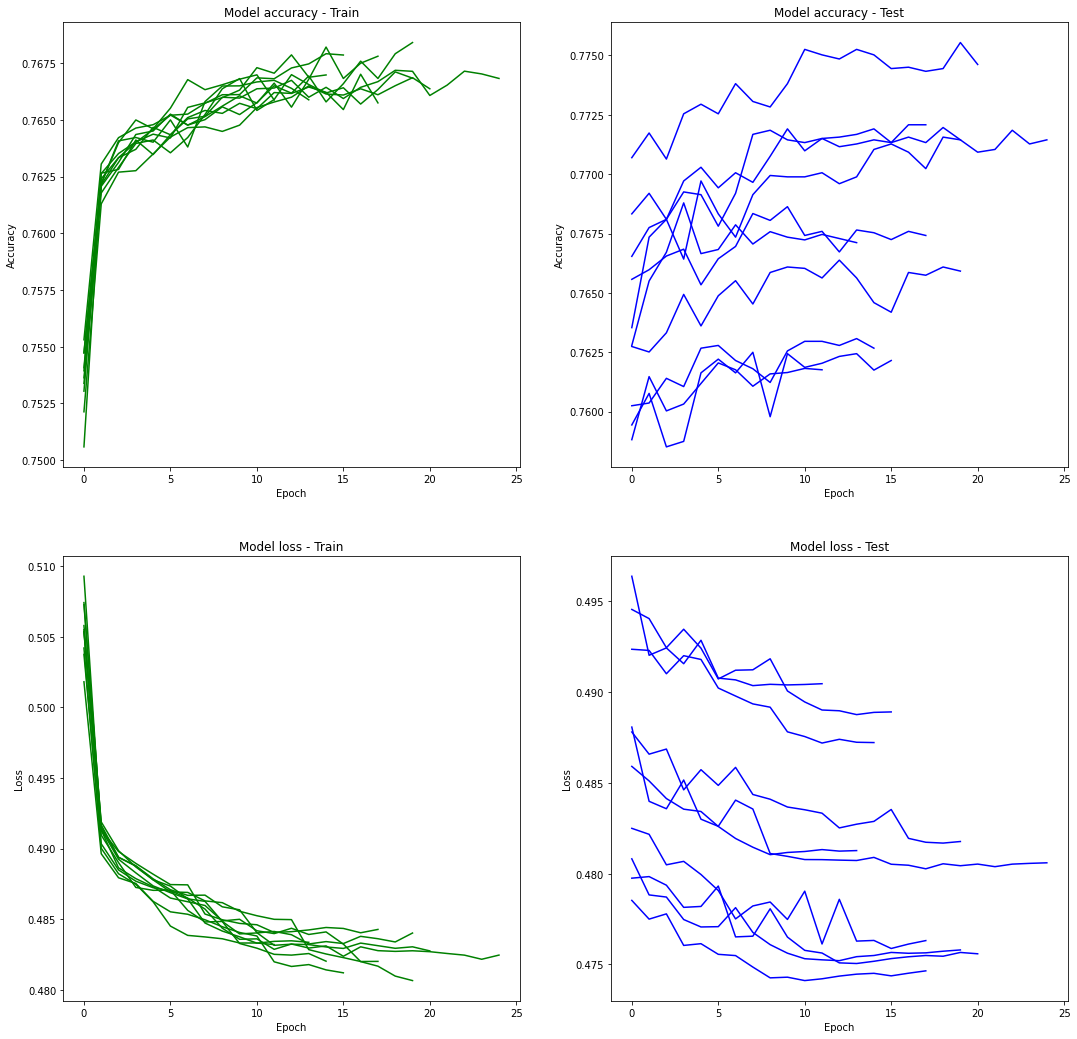

In [30]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(2, 2, figsize=(18,18))

# accuracy
for h in histories:
    axs[0,0].plot(h.history['accuracy'], color='g')
axs[0,0].set_title('Model accuracy - Train')
axs[0,0].set_ylabel('Accuracy')
axs[0,0].set_xlabel('Epoch')

for h in histories:
    axs[0,1].plot(h.history['val_accuracy'], color='b')
axs[0,1].set_title('Model accuracy - Test')
axs[0,1].set_ylabel('Accuracy')
axs[0,1].set_xlabel('Epoch')

# loss
for h in histories:
    axs[1,0].plot(h.history['loss'], color='g')
axs[1,0].set_title('Model loss - Train')
axs[1,0].set_ylabel('Loss')
axs[1,0].set_xlabel('Epoch')

for h in histories:
    axs[1,1].plot(h.history['val_loss'], color='b')
axs[1,1].set_title('Model loss - Test')
axs[1,1].set_ylabel('Loss')
axs[1,1].set_xlabel('Epoch')

fig.show()